In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import import_ipynb
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import random
import operator

from tqdm import tqdm as prog_bar

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device available: ", device, " ", torch.cuda.get_device_name(0))

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#import model
%cd ..
%cd "protein-ppi-encoding-module"
from transformerGO import *

%cd .. 
%cd "training-testing"
from training_helper import * 

#import dataset functions
%cd ..
%cd "datasets"
from dataset_manip import *
%cd .. 

#for np array from nested sequences
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

Device available:  cuda   GeForce GTX 960M
C:\Users\Ieremie\Desktop\TransformerGO\TransformerGO
C:\Users\Ieremie\Desktop\TransformerGO\TransformerGO\protein-ppi-encoding-module
importing Jupyter notebook from transformerGO.ipynb
importing Jupyter notebook from harvard_transformer.ipynb
C:\Users\Ieremie\Desktop\TransformerGO\TransformerGO
C:\Users\Ieremie\Desktop\TransformerGO\TransformerGO\training-testing
importing Jupyter notebook from training_helper.ipynb
C:\Users\Ieremie\Desktop\TransformerGO\TransformerGO
C:\Users\Ieremie\Desktop\TransformerGO\TransformerGO\datasets
importing Jupyter notebook from dataset_manip.ipynb
C:\Users\Ieremie\Desktop\TransformerGO\TransformerGO


In [3]:
organism = 4932
organism_name = "yeast"
EMB_DIM = 64

data_path = 'datasets/onto2vec-datasets-string/data'
go_embed_pth = f"term-encoding-module/emb/go-terms-{EMB_DIM}.emd"
go_id_dict_pth = "term-encoding-module/go_id_dict"
protein_go_anno_pth = data_path +"/sgd.gaf.gz"
alias_path = data_path + f'/{organism}.protein.aliases.v11.0.txt.gz'

neg_path_train = data_path + f'/train/{organism}.no-mirror.negative_interactions.txt'
poz_path_train = data_path + f'/train/{organism}.no-mirror.protein.links.v11.0.txt'

train_set = get_dataset_split_stringDB(poz_path_train, neg_path_train, protein_go_anno_pth, go_id_dict_pth, go_embed_pth,\
                                       None, alias_path, ratio = [1, 0, 0], stringDB = True)[0]
print("Train set: ", len(train_set))

def helper_collate(batch):
    MAX_LEN_SEQ = get_max_len_seq(batch)
    return transformerGO_collate_fn(batch, MAX_LEN_SEQ, EMB_DIM, pytorch_pad = False)

params = {'batch_size': 32,'collate_fn': helper_collate}
train_grt = data.DataLoader(train_set, **params, shuffle = False)

Rejected interactions where at least one protein has no annotation:  3637
Rejected interactions where go_filter=ALL and intr_set_size_filter=[0, 500]:  0
Number of interactions: 72556
Rejected interactions where at least one protein has no annotation:  18633
Rejected interactions where go_filter=ALL and intr_set_size_filter=[0, 500]:  0
Number of interactions: 57560
Train set:  130116


In [4]:
MODEL_SIZE = EMB_DIM
NR_HEADS = 8
NR_LAYERS = 3
DROPOUT = 0.3
SIZE_FF = 4 * MODEL_SIZE

model = TransformerGO_Scratch(MODEL_SIZE, NR_HEADS, NR_LAYERS, SIZE_FF, DROPOUT)
model.load_state_dict(torch.load(f'saved-models/model-{organism_name}-stringDB-benchmark-noMirror.pt'))
model = model.to(device)

In [5]:
def get_attn(layers, layer = 0, head = 0, avg = "HEAD", src_attn = False):     
    """ Function that extracts the weights from the attention mechanism
    Args:
        layers (model layers): layers from the encoder or decoder
        layer (int): index of the layer
        head (int): index of the head
        avg (string): type of averaging of the attention: 
                        "NONE", average over heads "HEAD", average over all layers "Layer", average over all layers and heads "ALL"
        src_attn (bool): the extraction of source attention from the layers or the self attention

    Returns:
    numpy: numpy containing the averaged attention
    """
        
    if src_attn:
        attn = layers[layer].src_attn.attn
    else:
        attn = layers[layer].self_attn.attn
    if avg == "NONE":
        return attn[0, head].data
    if avg == "HEAD":
        return torch.mean(attn[0], dim = 0)
    
    
    attn = torch.zeros(layers[0].self_attn.attn.shape).to(device)
    for l in layers:
        if src_attn:
            attn = torch.cat((attn, l.src_attn.attn))
        else:
            attn = torch.cat((attn, l.self_attn.attn))
    
    attn = torch.mean(attn, dim = 0)
    if avg == "LAYER":
        return attn[head]
    elif avg == "ALL":
        return torch.mean(attn, dim = 0)

In [6]:
def add_to_heatmap(heatm, go_id_dict, protA, protB, attn):
    
    """ Function that adds attention weights to a heatmap
    Args:
        heatm (numpy): matrix to add the attention and freq to
        go_id_dict (dict): dictionary of mapping 'GO-name -> 1'
        protA (list): list of GO terms annotated to protA
        protB (list): list of GO terms annotated to protB
    """
        
    for i in range(len(protA)):
        go1 = go_id_dict[protA[i]]
        for j in range(len(protB)):
            go2 = go_id_dict[protB[j]]
            #attn 
            heatm[go1,go2][0] +=  attn[i][j].cpu()
            # frequency
            heatm[go1,go2][1] +=  1

In [7]:
def remove_unused_go(go_id_dict, data_grt):
    
    """ Function that removes GO terms from dictionary that do not appear in the dataset
    Args:
        go_id_dict (dict): dictionary of mapping 'GO-name -> 1'
        data_grt (DataLoader): generates data in batches

    Returns:
    dict: GO->id dictionary that is filterd down to remove go terms not appearning in the dataset 
    """
    for batch in data_grt:
        batch_ids = batch[3]
        for i in range( batch_ids.shape[0]):
            protA = batch_ids[i][0][1]
            protB = batch_ids[i][1][1]
            #mark those appearing
            for go in protA + protB:
                go_id_dict[go] = -1
                
    go_id_dict = {k: v for k, v in go_id_dict.items() if v == -1}
    go_id_dict = dict(zip(go_id_dict.keys(), np.arange(len(go_id_dict))))
    return go_id_dict

In [8]:
def get_filtered_heatmap(go_heatm_sc, indexs, selected = "BOTH"):
    """ Function that removes lines and columns from heatmap
    Args:
        go_heatm_sc (numpy): heatmap of the GO terms
        indexs (list): list of indexes where the GO terms are not present in the dataset
        selected (string): "ROW" removes only rows, "COLUMN" removes only columns, "BOTH" removes both

    Returns:
    numpy: the new heatmap with the corresponding columns or rows removed
    """
    
    if selected == "BOTH":
        filt_go_heatm = go_heatm_sc[indexs]
        return filt_go_heatm[:,indexs]
    if selected == "ROW":
        return go_heatm_sc[indexs]
    if selected == "COLUMN":
        return go_heatm_sc[:,indexs]

In [9]:
def get_top_sorted_attn(go_heatm_sc, number_of_go, axis):
    
    """ Function that selects the GO indexes in the heatmap that have the highest attention
    Args:
        go_heatm_sc (numpy): heatmap of the GO terms
        number_of_go (int): how many GO terms to select from the highest attention values
        axis (int): attention is summed over columns or rows 

    Returns:
    list: GO indexes values coresponding to the rows and columns in the heatmap
    """
   
    #summed attention with position in matrix
    sumed_attn_dic, indxs = zip(*sorted(zip(np.sum(go_heatm_sc, axis = axis), np.arange(len(go_heatm_sc))), key=lambda x: x[0]))
    
    #return the top go terms with high attention 
    return indxs[-number_of_go:]


def get_filtered_indexes(go_heatm_sc, number_of_go, top = True, attn = "FOCUSED"):
    
    """ Function that selects the GO indexes in the heatmap that have the highest attention
    Args:
        go_heatm_sc (numpy): heatmap of the GO terms
        number_of_go (int): how many GO terms to select from the highest attention values
        top (bool): choose the top GO terms with high attention or those with low attention
        attn (string): "FOCUSED" means calulating the attention over columns, while "CONTRIBUTED" over rows
 
    Returns:
    list: GO indexes values coresponding the rows and columns in the heatmap
    """
    
    assert attn == "FOCUSED" or attn == "CONTRIBUTED", \
          "Invalid attn input, it should be FOCUSED or CONTRIBUTED"

    #return the top go terms
    if attn == "FOCUSED":
        return get_top_sorted_attn(go_heatm_sc, number_of_go, axis = 1)
    else:
        return get_top_sorted_attn(go_heatm_sc, number_of_go, axis = 0)

In [10]:
def idstogos(ids, go_id_dict):
    key_list = list(go_id_dict.keys())
    val_list = list(go_id_dict.values())  
    return [key_list[val_list.index(go_id)] for go_id in ids]

def gostoids(gos, go_id_dict):
    return [go_id_dict[go] for go in gos]

In [11]:
def get_heamaps(go_id_dict, condition_helper, dict_path, model = model, train_grt = train_grt, mode = None):
    
    """ Function that generates the M attention matrix (both self and source) containing all the attention
        values between the GO terms in the given dataset
    Args:
        go_id_dict (dict): Mapping between go name and id e.g. GO1 -> 1
        condition_helper (funct): function that checks whether the interaction is of a certain type
        dict_path (str): path to the dictionary of mapping ProtA -> 'intr type' (e.g. High Throughput)
        model (TransformerGO): trained model which is used to analyse the weigths
        train_grt (Dataset_stringDB): the dataset used for training the model
        mode (str): the type of interaction we are looking at e.g. 'High thorghput'

    Returns:
    numpy: Attention matrix for the source and self attention 
    """
    
    with open(dict_path, 'rb') as handle:
        actions = pickle.load(handle)
    
    l = len(go_id_dict)
    # 2 = (attn_sum, number_of_attn_added_to_sum)
    go_heatm_self = np.zeros(l * l * 2).reshape(l,l,2)
    go_heatm_source = np.zeros(l * l * 2).reshape(l,l,2)

    model.eval()
    with torch.no_grad():
            added = 0
            for batch in prog_bar(train_grt):
                #padded pairs: tensor of shape N * 2(protein pair) * L(longest seq) * Emb dim
                padded_pairs = batch[0].to(device)
                labels = batch[1].to(device)
                mask = batch[2].to(device)
                batch_ids = batch[3]
            
                #swap seqLen with batch to fit the transformer
                gosetA_batch = padded_pairs[:,0]
                gosetB_batch = padded_pairs[:,1] 
            
                #only for 1 protein pair at a time
                for i in range(0, batch[0].shape[0]):
                    
                    protA = batch_ids[i][0][1]
                    protB = batch_ids[i][1][1]
                    
                    if mode is None or condition_helper(mode, labels, i, batch_ids, actions):
                        
                        added += 1
                        pred = model(gosetA_batch[i].unsqueeze(0), gosetB_batch[i].unsqueeze(0), \
                                             mask[i,0].unsqueeze(0), mask[i,1].unsqueeze(0)).squeeze(1)

                        attn = get_attn(model.encoder.layers, avg = "ALL")
                        add_to_heatmap(go_heatm_self, go_id_dict, protA, protA, attn)

                        attn = get_attn(model.decoder.layers, avg = "ALL")
                        add_to_heatmap(go_heatm_self, go_id_dict, protB, protB, attn)
                        
                        attn = get_attn(model.decoder.layers, avg = "ALL", src_attn = True)
                        add_to_heatmap(go_heatm_source, go_id_dict, protB, protA, attn)  
            print("Number of interactions added:", added)
    return go_heatm_self, go_heatm_source

In [12]:
def experiment_condition_helper(req_experiment, labels, i, batch_ids, expr_type_dict):
    """ Function that checks if the current interaction is coming from a certain experiment
         eg. 'High throughput'
    Args:
        req_experiment (string): name of the experiment to look for
        labels (list): labels 1 or 0 for the type of interaction poz or neg
        i (int): counter of the protein in the train_generator
        batch_ids (numpy): information about the name of proteins and name of GO terms
        expr_type_dict (dict): dictionary for the types of interactions eg. ProtAProtB -> 'High thorughput'

    Returns:
    bool: true if the interaction is the desired type 
    """
    if labels[i] == 1:
        experiment_type = expr_type_dict[batch_ids[i][0][0]+batch_ids[i][1][0]] #protAid + protBid
        if experiment_type == req_experiment:
            return True
    return False

In [13]:
def load_filtered_go_id_dict(name = 'attention-analysis/go-graph-attention/go_id_dict_filtered_human'):
    with open(name, 'rb') as fp:
        go_id_dict = pickle.load(fp)
    return go_id_dict   

def save_filtered_go_id_dict(name = 'go_id_dict_filtered_yeast'):
    
    """ Function that removes GO terms from the dictionary that do not appear in the dataset
        This ensures a consistent mapping between the position in the matrix and GO id
        e.g. GO term with id '0' will have the position 0 in the matrix
    Args:
        name (string): the name of the file where the dict is saved
    Returns:
    dict: filtered dictionary
    """
    %cd term-encoding-module
    with open("go_id_dict", 'rb') as fp:
        go_id_dict = pickle.load(fp)
        go_id_dict = remove_unused_go(go_id_dict, train_grt)
    %cd ..
    
    with open(name, 'wb') as fp:
        pickle.dump(go_id_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
    return go_id_dict

In [14]:
def get_final_hm(go_heatm, number_of_go,  dim = 1):
     
    """ Function that filteres the attention matrix M to contain
    only a number of go terms with high attention, and uses
    softmax with temperature to better highlight the attention values
    Args:
        go_heatm (numpy): the attention matrix
        number_of_go (int): how many top go terms to keep
        dim (int): on what dimension to comput the sum (e.g. 1 means over the columns)
    Returns:
    numpy: filtered attention matrix
    list: the list of the indices of the selected terms
    """
    
    #retrieving the freq from the (l,l,2) matrix
    go_freq = go_heatm[:,:,1]
    #retrieving the attention sum
    go_heatmap = go_heatm[:,:,0]
    
    go_heatm_sc = go_heatmap/np.where(go_freq==0, 1e9, go_freq)
    indexs = get_filtered_indexes(go_heatm_sc, number_of_go, top = True, attn = "FOCUSED")
    
    #sort the indexes such that same go terms appear at the begining of the heatmap
    indexs = sorted(indexs)
    
    filt_go_heatm = get_filtered_heatmap(go_heatm_sc, indexs, selected = "BOTH")

    #perform softmax with temperature to better highligh the attention values
    tmpr = 0.01
    filt_go_heatm = np.where(filt_go_heatm==0, -1e9, filt_go_heatm)
    go_heatm_soft = F.softmax(torch.from_numpy(filt_go_heatm/tmpr), dim = dim)
    
    return go_heatm_soft, indexs

In [15]:
def save_heatmaps(organism, mode, go_heatm_self, go_heatm_source):
    np.savez_compressed(f'{organism}-{mode}-go_heatm_self', go_heatm_self)
    np.savez_compressed(f'{organism}-{mode}-go_heatm_source', go_heatm_source)

def load_heatmaps(organism, mode, path = 'experiments-results/experiment-type-biogrid/'):
    go_heatm_self = np.load(f'{path}{organism}-{mode}-go_heatm_self.npz')['arr_0']
    go_heatm_source = np.load(f'{path}{organism}-{mode}-go_heatm_source.npz')['arr_0']
    
    return go_heatm_self, go_heatm_source

In [16]:
import seaborn
go_id_dict = load_filtered_go_id_dict(name = f'attention-analysis/go-graph-attention/go_id_dict_filtered_{organism_name}')
mode = 'High Throughput'

dict_path = f'datasets/experiment-type-biogrid/{organism}.no-mirror.protein.links.v11.0.txt.experiment_type_dict'
go_heatm_self, go_heatm_source = get_heamaps(go_id_dict, experiment_condition_helper, dict_path, mode = mode) 
#go_heatm_self, go_heatm_source = load_heatmaps(organism_name, mode , path = '')
#save_heatmaps(organism_name, mode, go_heatm_self, go_heatm_source)

100%|██████████████████████████████████████████████████████████████████████████████| 4067/4067 [31:17<00:00,  2.17it/s]

Number of interactions added: 13866


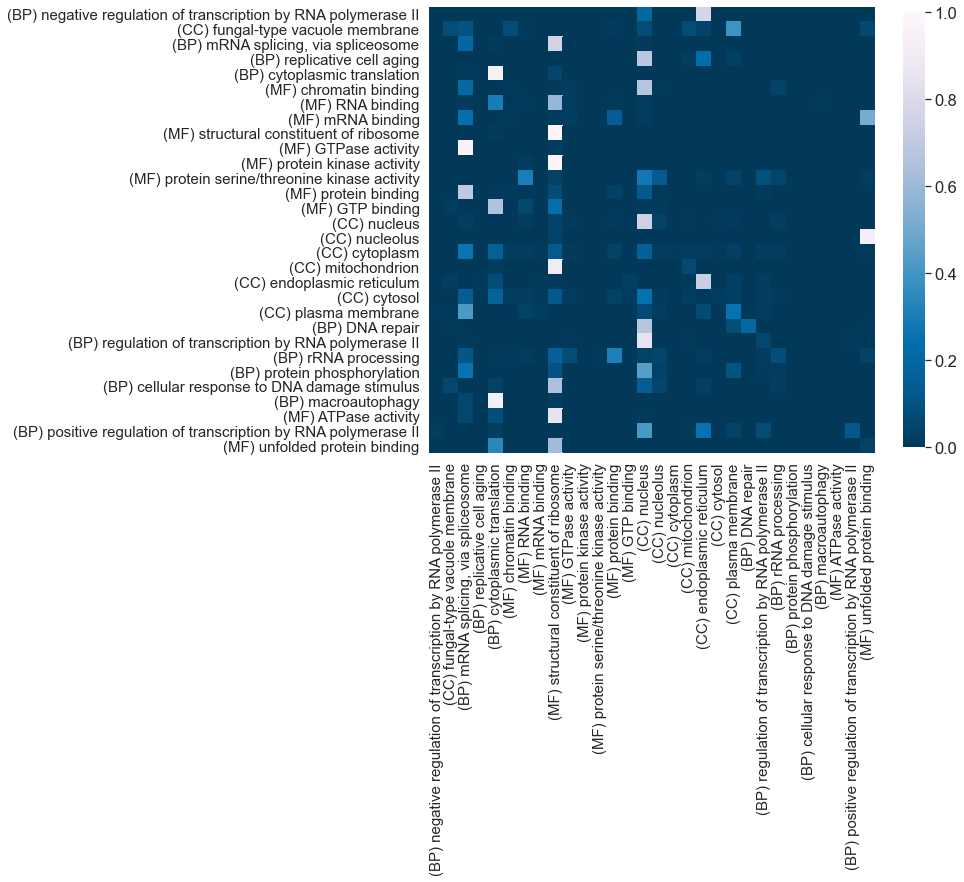

In [18]:
number_of_go = 30
act_src_hm, act_indexs = get_final_hm(go_heatm_source, number_of_go = number_of_go)

labels = idstogos(act_indexs, go_id_dict)
expls = get_GO_explanation(labels, obo_csv_path = "term-encoding-module/go-basic.obo.csv")
labels = ['('+m+')' + " " + n for m,n in zip(process_to_capital(expls['namespace']), trim_GO_expl(expls['name']))]  

sns.set(font_scale=1.5)
fig, ax = plt.subplots(1,1, figsize=(10, 10))
hm = sns.heatmap(act_src_hm, ax=ax, vmax = 1, vmin = 0, square = True, cbar_kws={"shrink": 0.80}, cmap="PuBu_r") 

ax.tick_params(labelsize=15)
hm.set_xticks( np.arange(len(labels)) + 0.5) #+ 0.5 to center the label
hm.set_yticks( np.arange(len(labels)) + 0.5)
hm.set_xticklabels(labels=labels, rotation=90);
hm.set_yticklabels(labels=labels, rotation=0);

rect = fig.patch
rect.set_facecolor('white')
#plt.savefig(f"{organism_name}-{mode}-source-top-{number_of_go}.eps",  facecolor=fig.get_facecolor(), bbox_inches = 'tight')